# There should have been other stuff but i guess that got deleted somehow...
Conclusion was that n_g has next to none effect on the fidelity

In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
# using DiffEqFlux
# using Optim
# using ForwardDiff
using DelimitedFiles
using LineSearches

In [2]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [296]:
function limit_func(param,pmin,pmax)
    if pmin < param < pmax
        return param
    elseif param <= pmin
        return pmin
    else
        return pmax
    end
end

function alpha(p, t)
    Tₐ = limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    αmin = limit_func(p[4],0.5,1)
    abs_slope = (1 - αmin)/Tₐ
    if t < Tₐ
        return 1 - abs_slope * t
    elseif t > Tₐ + Tₚ
        return αmin + abs_slope * (t - Tₐ - Tₚ)
    else
        return αmin
    end
end

function envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    if Tₐ < t < Tₐ + Tᵣ
        arg = pi / 2 * (t - Tₐ) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*pi/(2*Tᵣ)
    elseif Tₐ + Tᵣ <= t <= Tₐ + Tₚ - Tᵣ
        E *= 1
        Edot *= 0
    elseif Tₐ + Tₚ - Tᵣ < t < Tₐ + Tₚ
        arg = pi / 2 * (Tₐ + Tₚ - t) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*(-pi)/(2*Tᵣ)
    else
        E *= 0
        Edot *= 0
    end
    return (E, Edot)
end

function pulse(p, t)
    Tₐ = limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    Tᵣ = limit_func(p[1],0,Tₚ/2)
    # αmin = p[4]
    ϕ = p[5]
    f = p[6]
    A = p[7]
    # Φ_ext = p[8]
    λ = p[9]

    amp = pi * A / (Tₚ - Tᵣ)
    E = amp
    Edot = amp
    E, Edot = envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    arg = f*(t - Tₐ) + ϕ
    return E*cos(arg) + Edot*λ*sin(arg)
end

pulse (generic function with 1 method)

In [294]:
p = [1.8096066788458205,
10.151415509076779,
10.0,
0.7265360232227066,
2.819743639160394,
2.0448639414672374,
4.08982325027897,
3.1258846903218442,
0.03571156893603993];

In [5]:
times = LinRange(0,30,2000)

2000-element LinRange{Float64, Int64}:
 0.0,0.0150075,0.030015,0.0450225,…,29.925,29.94,29.955,29.97,29.985,30.0

In [9]:
ψs = eigvecs(Matrix(KinPot12 + Potential3))

function H!(du, u, p, t)
    du[:] = -im .* ((KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling) * u)
end

forward_prob = ODEProblem(H!, ψs[:,1:2], (0.0, 30.0), p)
sol = solve(forward_prob, p=p, saveat=times, reltol=1e-8, abstol=1e-10)

retcode: Success
Interpolation: 1st order linear
t: 2000-element Vector{Float64}:
  0.0
  0.015007503751875937
  0.030015007503751873
  0.04502251125562781
  0.06003001500750375
  0.07503751875937968
  0.09004502251125562
  0.10505252626313157
  0.1200600300150075
  0.13506753376688344
  ⋮
 29.879939969984992
 29.89494747373687
 29.909954977488745
 29.92496248124062
 29.939969984992498
 29.954977488744372
 29.969984992496247
 29.984992496248125
 30.0
u: 2000-element Vector{Matrix{ComplexF64}}:
 [7.458437020914339e-10 + 1.9551902702793405e-19im 7.165380802393358e-10 - 4.465451818806265e-19im; 4.750172604670167e-9 - 2.4109872830822624e-9im 4.545922347254764e-9 + 2.4419982821121935e-9im; … ; 4.750172562092263e-9 + 2.410987280507997e-9im 4.545922304677384e-9 - 2.441998265656064e-9im; 7.458437153439597e-10 + 0.0im 7.16538051171195e-10 + 0.0im]
 [2.8565317330440146e-10 + 6.889250751663094e-10im 2.8968684557413584e-10 + 6.553175249132533e-10im; 4.046144799106249e-9 + 3.464309968004157e-9im -3

In [16]:
occs = zeros(Float64,length(sol.t),2,2)

for (i, t) in enumerate(sol.t)
    Es, ψs = eigs(KinPot12 + alpha(p,t) .* Potential3, nev=2, which=:SR)
    occs[i,:,:] = abs2.(ψs'*sol.u[i])
end

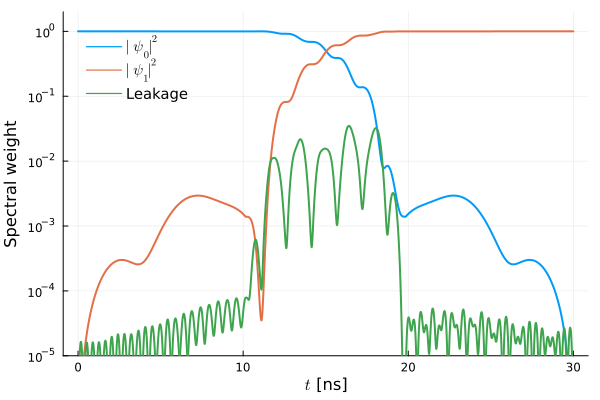

In [144]:
# using Markdown
using LaTeXStrings
plt = plot(sol.t,
     [occs[:,1,1], occs[:,2,1], abs.(1 .- (occs[:,1,1] + occs[:,2,1]))],
     yaxis=:log10,
     ylim=(1e-5,2),
     linewidth=2,
     yticks=[10^i for i=-5.:0],#(append!([i*10^j for i = 1:9 for j = -5.:-1],[1]),tmp)
     xlabel=L"$t$ [ns]",
     ylabel="Spectral weight",
     label=[L"$|\psi_0|^2$" L"|\psi_1|^2" "Leakage"],
     legend=:topleft,
     background_color_legend = nothing,
     foreground_color_legend = nothing,
     legendfontsize=10
)

In [145]:
# savefig(plt,"HighFidelitySwapOccupation.png")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\nQUncertainty\\HighFidelitySwapOccupation.png"

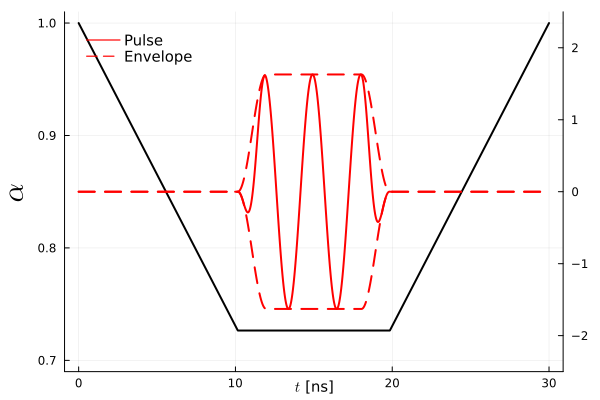

attempt to save state beyond implementation limit


In [305]:
tmp_p = copy(p)
tmp_p[6] = 0
tmp_p[9] = 0
tmp_p[5] = 0

plt = plot(times,
     [alpha(p,t) for t in times],
     ylim=(0.69,1.01),
     linewidth=2,
     color="black",label=nothing,
     labelfontsize=20,ticklabelfontsize=20,
      ylabel=L"$\alpha$")

plot!(twinx(),
      [times[666:1333],times,times],
      [[pulse(p,t) for t in times[666:1333]],[pulse(tmp_p,t) for t in times],[-pulse(tmp_p,t) for t in times]],
      linewidth=2,
      color=[:red :red :red],
      ylim=(-2.5,2.5),
      ls = [:solid :dash :dash],
      label=["Pulse" "Envelope" ""],
      legend=:topleft,
      background_color_legend = nothing,
      foreground_color_legend = nothing,
      legendfontsize=10,
      labelfontsize=10,
      ticklabelfontsize=20,
      xlabel=L"$t$ [ns]")

In [219]:
# savefig(plt,"HighFidelitySwapGatePulse.png")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\nQUncertainty\\HighFidelitySwapGatePulse.png"

In [183]:
N = 20

function envelope(t)
    if t < 2
        return sin(pi/4*t)^2
    elseif 28 < t <= 30
        return cos(pi/4*(t-28))^2
    else
        return 1
    end
end

h_times = LinRange(0,30,N+2)[2:end-1]
dt = h_times[1]
function pulse(p, t)
    out = 0
    w_sum = 0
    for (i, ht) in enumerate(h_times)
        w = exp( - 100/(2*dt^2) * (t - ht)^2)
        out += p[i] * w
        w_sum += w
    end
    out/w_sum
    # envelope(t)*out/w_sum
end
function exps(p, ht,t)
    p*exp( - 10/(2*dt^2) * (t - ht)^2)
end


exps (generic function with 1 method)

In [142]:
p = rand(N) .* 2 .- 1
# p[1] = 0
# p[:] = -1 .* p
;

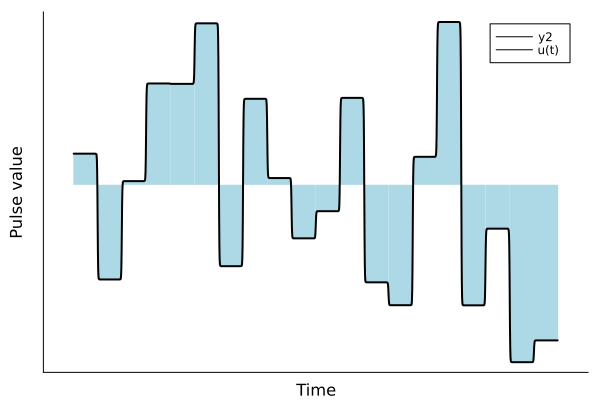

In [190]:
plt = bar(h_times,p,
    linestyle=:solid,
    linewidth=0,
    linecolor=:lightblue,
    fillcolor=:lightblue,
    bar_width=1.43,
    label=nothing,
    yticks=nothing,xticks=nothing,
    xlabel="Time", ylabel="Pulse value",left_margin = 5Plots.mm)

# xs = Vector(h_times)
# plot!([reshape(xs .- xs[1],1,20); reshape(xs,1,20)],[reshape(p,1,20);reshape(p,1,20)],
#       color=:black,linestyle=:solid,linewidth=2,label=nothing)
plot!(times[50:end-50],[pulse(p,t) for t in times[50:end-50]],color=:black,linewidth=2,ls=:solid,yticks=nothing,xticks=nothing,xlabel="Time", ylabel="Pulse value",left_margin = 5Plots.mm)

plot!([],[],label="u(t)",color=:black,linestyle=:solid,linewidth=2)
# plot!([[1 2 3] ; [2 3 4]], [[-1 0 1];[-1 0 1]])

In [191]:
savefig(plt,"PieceWiseInterpolation.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\nQUncertainty\\PieceWiseInterpolation.pdf"

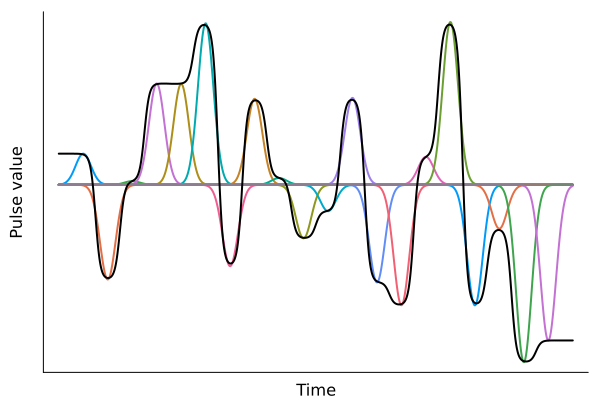

In [181]:
plt = plot(times,[[exps(p[i],h_times[i], t) for t in times] for i in 1:N],legend=nothing,linewidth=2)
plot!(times,zeros(length(times)),color=:grey,lw=2.2,alpha=0.8)
plot!(times,[pulse(p,t) for t in times],color=:black,linewidth=2,ls=:solid,yticks=nothing,xticks=nothing,xlabel="Time", ylabel="Pulse value",left_margin = 5Plots.mm)
plot!([],[],label="u(t)",color=:black,linestyle=:solid,linewidth=2)

In [182]:
# savefig(plt,"GaussianInterpolation.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\nQUncertainty\\GaussianInterpolation.pdf"

In [291]:
occs = zeros(Float64,length(sol.t),2,2)

for (i, t) in enumerate(sol.t)
    Es, ψs = eigs(KinPot12 + alpha(p,t) .* Potential3, nev=2, which=:SR)
    occs[i,:,:] = abs2.(ψs'*sol.u[i])
end

2000-element Vector{Float64}:
  0.0
  0.015007503751875937
  0.030015007503751873
  0.04502251125562781
  0.06003001500750375
  0.07503751875937968
  0.09004502251125562
  0.10505252626313157
  0.1200600300150075
  0.13506753376688344
  ⋮
 29.879939969984992
 29.89494747373687
 29.909954977488745
 29.92496248124062
 29.939969984992498
 29.954977488744372
 29.969984992496247
 29.984992496248125
 30.0